<a href="https://colab.research.google.com/github/gnomez1208/gnomez1208/blob/Dark-Matter-Research/LDR__2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install uproot

from google.colab import files

print("Please select 'output03048.root' from your Ubuntu machine.")
uploaded = files.upload()
#saved onto google colab local file environment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.8/383.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.0/887.0 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 651.6/651.6 kB 17.2 MB/s eta 0:00:00
Please select 'output03048.root' from your Ubuntu machine.


Saving output03048.root to output03048.root


Analyzing 5205 waveforms to find single-peak events...

Analysis complete. Kept 303 clean single-peak events.

--- Final SPE Calibration Results ---
Pedestal Charge Peak: 1400.75 ADC*samples
1 PE Charge Peak:     2201.42 ADC*samples
1 PE Charge Sigma:    510.67 ADC*samples
Separation (S/N):     1.32


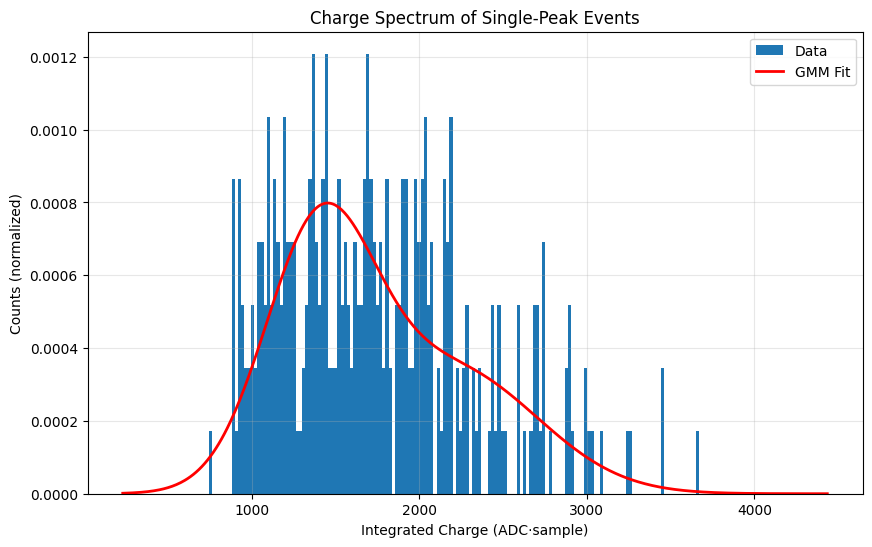

In [40]:

import uproot
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

file_path = "/content/output03048.root"

# Main Analysis Code
# =========================================================

#Analysis Parameters
sampling_frequency = 250e6  # 250 MHz

# Baseline and Noise
pre_ns = 500  # ns of pre-trigger region for baseline calculation
pre_samp = int(pre_ns * 1e-9 * sampling_frequency)

# Bandpass filter for finding peaks (not for integration)
bp_lo, bp_hi = 5e6, 50e6  # 5 MHz to 50 MHz
b, a = butter(2, [bp_lo / (sampling_frequency / 2), bp_hi / (sampling_frequency / 2)], btype="band")

# Peak selection criteria/ "the pretty ones"
min_width_ns, max_width_ns = 12, 200  # Pulse width in ns
min_width = max(1, int(min_width_ns * 1e-9 * sampling_frequency))
max_width = int(max_width_ns * 1e-9 * sampling_frequency)
prom_sigma = 7  # Prominence threshold in units of noise sigma|making it higher to truly clean out any noise compared to previous lower sigmas

# Integration window relative to the peak location
int_pre_ns, int_post_ns = 8, 100  # ns before and after the peak
int_pre = int(int_pre_ns * 1e-9 * sampling_frequency)
int_post = int(int_post_ns * 1e-9 * sampling_frequency)

# Pile-up rejection
refractory_ns = 200  # ns window to ensure peaks are isolated
refractory = int(refractory_ns * 1e-9 * sampling_frequency)

# Find Peaks
#=================================

def baseline_stats(x, pre=pre_samp):
    """Robust baseline and noise estimation using median and MAD."""
    r = x[:pre]
    med = np.median(r)
    mad = np.median(np.abs(r - med))
    sigma = 1.4826 * mad if mad > 0 else np.std(r) #assuming normal distribution with 1.48 * MAD
    return med, sigma

def detect_peaks(x_raw):
    """Finds clean, isolated peaks in a single waveform."""
    base, sig = baseline_stats(x_raw)
    x0 = x_raw - base
    # Use a bandpass filter only for reliable peak *detection*
    xf = filtfilt(b, a, x0) if len(x0) > 3 * max(1, min_width) else x0

    peaks, _ = find_peaks(
        -xf,  # Invert for negative pulses
        prominence=prom_sigma * sig,
        width=(min_width, max_width)
    )

    # Applying the refractory period to reject pile-up
    if len(peaks) > 1:
        keep = [peaks[0]]
        for p in peaks[1:]:
            if p - keep[-1] >= refractory:
                keep.append(p)
        peaks = np.array(keep, dtype=int)

    return peaks, base

def integrate_charge(x_raw, peak_idx, base):
    """Integrates the charge of a single peak on the raw, baseline-subtracted data."""
    x0 = x_raw - base
    a = max(0, peak_idx - int_pre)
    b = min(len(x0), peak_idx + int_post)
    # Use trapezoidal integration for better accuracy | similar to Reimmann Sums
    q = np.trapezoid(x0[a:b])
    return -q  # Invert back to get a positive charge

#  Global Analysis Loop
#==================================
all_charges = []
num_waveforms_to_process = 5205 # Use a large number for good statistics

with uproot.open(file_path) as file:
    keys = file.keys()
    waveforms_to_process = min(num_waveforms_to_process, len(keys))

    print(f"Analyzing {waveforms_to_process} waveforms to find single-peak events...")

    for i in range(waveforms_to_process):
        waveform_np = file[keys[i]].values()

        # Find peaks in this waveform
        peaks, base = detect_peaks(waveform_np)

        # CRUCIAL STEP: Only keep events with exactly ONE detected peak
        if len(peaks) == 1:
            q = integrate_charge(waveform_np, peaks[0], base)
            if q > 0: # Ensure charge is physical
                all_charges.append(q)

all_charges = np.array(all_charges)
print(f"\nAnalysis complete. Kept {len(all_charges)} clean single-peak events.")

# --- Fit the charge spectrum with a Gaussian Mixture Model ---
if len(all_charges) > 100:
    X = all_charges.reshape(-1, 1)
    # Fit two Gaussians: one for the pedestal (noise), one for the 1 PE peak
    gmm = GaussianMixture(n_components=2, random_state=0).fit(X)

    # Sort components by mean to identify pedestal and 1 PE
    means = gmm.means_.flatten()
    covs = gmm.covariances_.flatten()
    sort_idx = np.argsort(means)
    ped_mu, one_mu = means[sort_idx]
    ped_sigma, one_sigma = np.sqrt(covs[sort_idx])

    # Calculate signal-to-noise for the 1 PE peak
    separation = (one_mu - ped_mu) / np.sqrt(ped_sigma**2 + one_sigma**2)

    print(f"\n--- Final SPE Calibration Results ---")
    print(f"Pedestal Charge Peak: {ped_mu:.2f} ADC*samples")
    print(f"1 PE Charge Peak:     {one_mu:.2f} ADC*samples")
    print(f"1 PE Charge Sigma:    {one_sigma:.2f} ADC*samples")
    print(f"Separation (S/N):     {separation:.2f}")

    # Plot the Final Charge Histogram
    plt.figure(figsize=(10, 6))
    plt.hist(all_charges, bins=200, range=(ped_mu - 3*ped_sigma, one_mu + 4*one_sigma), density=True, label="Data")

    # Plot the GMM fit
    x_fit = np.linspace(plt.xlim()[0], plt.xlim()[1], 500).reshape(-1, 1)
    logprob = gmm.score_samples(x_fit)
    plt.plot(x_fit, np.exp(logprob), color='red', lw=2, label='GMM Fit')

    plt.xlabel("Integrated Charge (ADC·sample)")
    plt.ylabel("Counts (normalized)")
    plt.title("Charge Spectrum of Single-Peak Events")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

else:
    print("\nCould not find enough single-peak events to perform a reliable fit.")

In [41]:

import uproot
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, butter, filtfilt
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# 1. GENERAL PARAMETERS
# ===========================================
file_path = "/content/output03048.root"
sampling_period_ns = 4
pre_trigger_ns = 200
sampling_frequency = 1 / (sampling_period_ns * 1e-9)
pre_trigger_samples = int(pre_trigger_ns * 1e-9 * sampling_frequency)

# 2 Fltering Funcs
# ===================================================

def get_avg_spe_template(df, filtered_column, noise_sigma):
    """Finds clean, isolated peaks and averages them to create an SPE template."""
    peaks, _ = find_peaks(-df[filtered_column].dropna(),
                          prominence=(5 * noise_sigma), # Find very clean peaks
                          distance=100)
    if len(peaks) < 5:
            print(" Not enough clean peaks for a template. Using a generic Gaussian.")
            x = np.linspace(-5, 5, 40)
            template = -15 * np.exp(-x**2 / 4)
            return template

    templates = []
    for p in peaks:
            start, end = p - 20, p + 20
            if start > 0 and end < len(df):
                template_slice = df[filtered_column][start:end].values
                templates.append(template_slice - np.mean(template_slice[:5]))

    avg_template = np.mean(templates, axis=0)
    # Normalize to an amplitude of -1 for consistent scaling
    return avg_template / np.min(avg_template)

In [47]:
# Cell to Plot Raw Waveform with Approximate PE Height Lines (Flipped)


# 1. Select a waveform to inspect
#=========================================
waveform_index_to_plot = 810 # You can change this index
with uproot.open(file_path) as file:
    keys = file.keys()
    # THIS IS THE FIX: Select the key first, then get the values.
    waveform_np = file[keys[waveform_index_to_plot]].values()

    df_single = pd.DataFrame({'Raw ADC': waveform_np})
    df_single['Time (ns)'] = np.arange(len(df_single)) * 4.0

# 2. Calculate an "Effective SPE Height"
#=============================================

# This translates your global charge value (one_mu) into an approximate height.
baseline, sigma = baseline_stats(waveform_np)
df_single['Baseline Subtracted'] = df_single['Raw ADC'] - baseline

# Create an average pulse shape from this waveform to get the charge-to-height ratio
avg_template = get_avg_spe_template(df_single, 'Baseline Subtracted', sigma)
template_charge = -np.sum(avg_template)
template_height = -np.min(avg_template)

# Scale the template height by the ratio of the true SPE charge to the template charge
effective_spe_height = template_height * (one_mu / template_charge)

print(f"Visualization Parameters")
print(f"Global SPE Charge (one_mu): {one_mu:.2f}")
print(f"Effective SPE Height for this waveform: {effective_spe_height:.2f} ADC counts")


# 3. Plot
#=========================================================
fig_approx = go.Figure()

# Add the raw waveform trace
fig_approx.add_trace(go.Scatter(
    x=df_single['Time (ns)'], y=df_single['Raw ADC'],
    name='Raw Waveform', mode='lines'
))

# Add horizontal lines on the RAW waveform scale
fig_approx.add_hline(y=baseline, line_dash="dot", line_color="grey", annotation_text="Baseline")
fig_approx.add_hline(y=baseline - -effective_spe_height, line_dash="solid", line_color="springgreen", annotation_text="1 PE Level (Approx.)")
fig_approx.add_hline(y=baseline - -2 * effective_spe_height, line_dash="dash", line_color="gold", annotation_text="2 PE Level (Approx.)")
fig_approx.add_hline(y=baseline - -3 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="3 PE Level (Approx.)")
fig_approx.add_hline(y=baseline - -4 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="4 PE Level (Approx.)")
fig_approx.add_hline(y=baseline - -6 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="6 PE Level (Approx.)")

fig_approx.update_layout(
    title_text=f"Raw Waveform with Approximate SPE Levels (Waveform #{waveform_index_to_plot})",
    xaxis_title="Time (ns)",
    yaxis_title="Raw ADC Value",
    yaxis=dict(autorange='reversed')
)
fig_approx.show()

Visualization Parameters
Global SPE Charge (one_mu): 2201.42
Effective SPE Height for this waveform: -15.28 ADC counts


In [ ]:
import uproot

file_path = "/content/output03048.root"

print("Inspecting the contents of the ROOT file...")
print("="*40)

with uproot.open(file_path) as file:
    # This will show the name and type of every object in the top level of the file
    print("File contents (Name: Type):")
    all_objects = file.classnames()
    for name, class_type in all_objects.items():
        print(f"- {name}: {class_type}")

print("="*40)

Inspecting the contents of the ROOT file...
File contents (Name: Type):
- hwf_r3048e0c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e1c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e2c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e3c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e4c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e5c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e6c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e7c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e8c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e9c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e10c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e11c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e12c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e13c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e14c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e15c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e16c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e17c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e18c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e19c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e20c12_pmtge_hdo_reader;1: TH1F
- hwf_r3048e21c12_pmtge_hdo_reader;